<a href="https://colab.research.google.com/github/KDTEC/IP_proj/blob/master/Image_processing_project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *

### Data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/My\ Drive/data_IP/images.zip

Archive:  gdrive/My Drive/data_IP/images.zip
   creating: images/
 extracting: images/case_71_figura1.png  
 extracting: images/242a639e.jpg     
 extracting: images/cavitating-pneumonia-4-day28-PA.png  
 extracting: images/7E335538-2F86-424E-A0AB-6397783A38D0.jpeg  
 extracting: images/2C10A413-AABE-4807-8CCE-6A2025594067.jpeg  
 extracting: images/E1724330-1866-4581-8CD8-CEC9B8AFEDDE.jpeg  
 extracting: images/cavitating-pneumonia-4-day28-L.png  
 extracting: images/covid-19-caso-86-RX-Torace-2.jpg  
 extracting: images/chlamydia-pneumonia-PA.png  
 extracting: images/covid-19-pneumonia-14-PA.png  
 extracting: images/covid-19-pneumonia-24-day6.jpg  
 extracting: images/chlamydia-pneumonia-L.png  
 extracting: images/aspiration-pneumonia-5-day0.jpg  
 extracting: images/covid-19-pneumonia-14-L.png  
 extracting: images/5CBC2E94-D358-401E-8928-965CCD965C5C.jpeg  
 extracting: images/40f67745.jpg     
 extracting: images/430f21e7.jpg     
 extracting: images/3964b961.jpg     
 extracti

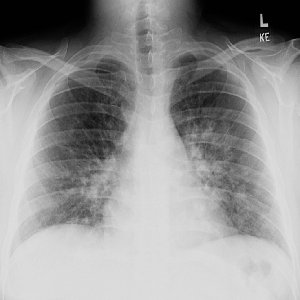

In [3]:
import tensorflow as tf
img = tf.keras.preprocessing.image.load_img('/content/images/000001-1.jpg',target_size=(300,300))
img

In [ ]:
path = Path('Path_to_the_X-ray_image_folders')

In [ ]:
np.random.seed(41)
data = ImageDataBunch.from_folder(path, train="Train", valid ="Valid",
        ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings', 'Pneumonia'], 3, 900, 225)

In [ ]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 900
Number of examples in validation: 225


In [ ]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

---

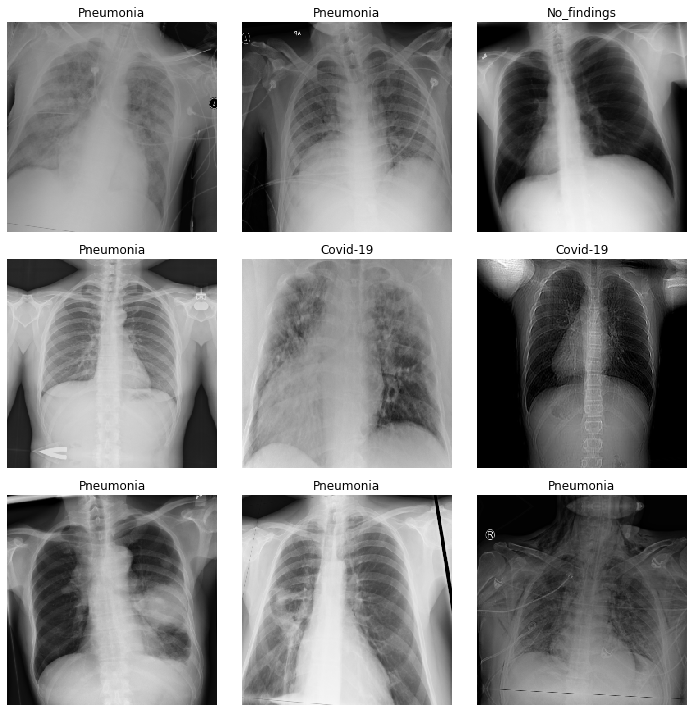

In [ ]:
data.show_batch(rows=3, figsize=(10,10))

Sharpening the Images

In [4]:
import cv2
import numpy as np
#  Importing function cv2_imshow necessary for programing in Google Colab
from google.colab.patches import cv2_imshow

Original Image


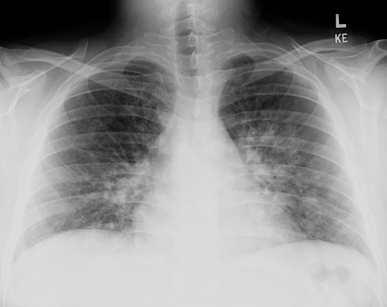

Sharpened Image


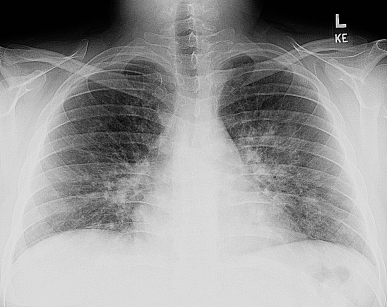

In [5]:
img1 = cv2.imread('/content/images/000001-1.jpg',1)
# Creating our sharpening filter
filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
# Applying cv2.filter2D function on our Cybertruck image
sharpen_img_1=cv2.filter2D(img1,-1,filter)
scale_percent = 40 # percent of original size
width = int(sharpen_img_1.shape[1] * scale_percent / 100)
height = int(sharpen_img_1.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized = cv2.resize(sharpen_img_1, dim, interpolation = cv2.INTER_AREA)
resized1 = cv2.resize(img1, dim, interpolation = cv2.INTER_AREA)
print("Original Image")
cv2_imshow(resized1)
print("Sharpened Image")
cv2_imshow(resized)

## DarkCovidNet (modified Darknet model)

In [ ]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )

In [ ]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [ ]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [ ]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 3),
    Flatten(),
    nn.Linear(507, 3)
)

In [ ]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

In [ ]:
learn.fit_one_cycle(100, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.858251,1.179491,0.484444,00:24
1,0.777954,0.643197,0.720000,00:24
2,0.723462,0.595972,0.720000,00:23
3,0.655952,0.565903,0.760000,00:24
4,0.628582,0.655289,0.706667,00:23
5,0.599323,0.541184,0.760000,00:23
6,0.584792,0.733112,0.737778,00:21
7,0.574960,0.585806,0.751111,00:21
8,0.585414,0.514000,0.786667,00:21
9,0.576228,0.533401,0.773333,00:21


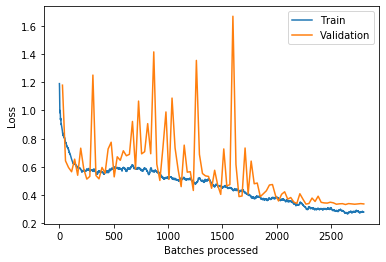

In [ ]:
learn.recorder.plot_losses()

In [ ]:
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 225


In [ ]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) # Predicting without TTA

In [ ]:
accuracy(probs,targets)

tensor(0.8933)

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings', 'Pneumonia'], 3, 900, 225)

In [ ]:
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) # shows whole confusion matrix
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings', 'Pneumonia']
print(classification_report(y_true1, y_pred1, target_names=target_names))

225 201 0.8933333333333333
[[ 24   1   3]
 [  0 102   7]
 [  1  12  75]]
              precision    recall  f1-score   support

    Covid-19       0.96      0.86      0.91        28
 No_findings       0.89      0.94      0.91       109
   Pneumonia       0.88      0.85      0.87        88

   micro avg       0.89      0.89      0.89       225
   macro avg       0.91      0.88      0.89       225
weighted avg       0.89      0.89      0.89       225



In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

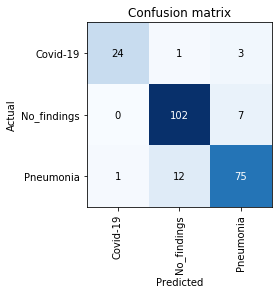

In [ ]:
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);